In [1]:
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Aghulas_20190510',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Aghulas_20190515']

In [18]:
scenario = 'Aghulas_20190515'
files = glob.glob(f"{data_dir+scenario}/*.nc")
files = [file for file in files if 'S1B' in file]
files

['/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172402-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172427-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172337-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172452-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172312-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc']

In [19]:
slice_max = 350

ts = []
for i, file in enumerate(files):
    data = xr.open_dataset(file)
    t = xr.concat([data.isel(swath = i).drop_dims('time') for i in range(data.dims['swath'])], dim = 'cell').doppler_centroid_anomaly#.plot()
    t = t.dropna(dim="cell")
    t = t.isel(cell = slice(0,slice_max))
    t.attrs.update(data.attrs)
    ts.append(t)
    # plt.figure()
    # t.plot(robust = True)

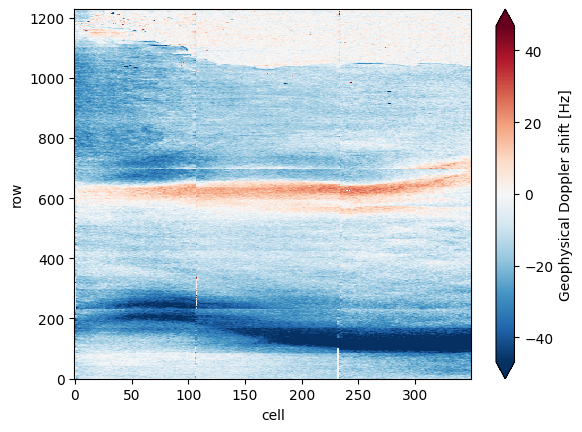

In [20]:
s = [t.attrs['time_coverage_start'] for t in ts]
position  = sorted(range(len(s)), key=lambda k: s[k])

tss =[ts[i] for i in position]

dca = xr.concat(tss, dim ='row', join='outer')
# dca = dca.isel(row = slice(250, 550))
dca.plot(robust = True)

## - Load Sentinel-1 file

In [21]:
dir_s1_file = f'/Users/opodriscoll/Documents/Data/Sentinel1/IW/{scenario}/'
path_s1_file = glob.glob(f"{dir_s1_file}/*.nc")
path_s1_file


['/Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc']

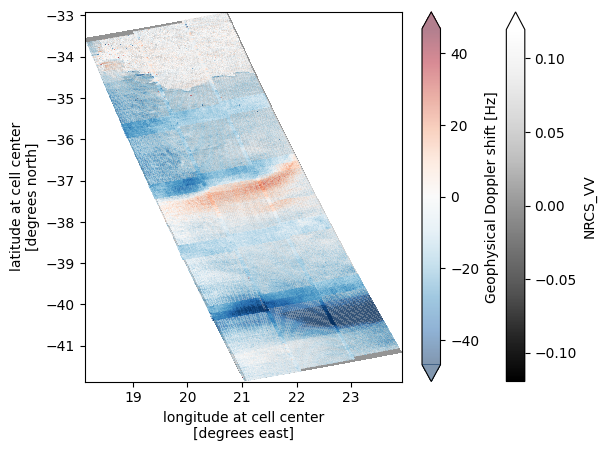

In [24]:
S1 = xr.open_dataset(path_s1_file[0])
S1 = xr.where(S1.NRCS_VV ==0, np.nan, S1)
S1 = S1.assign_coords({"lat": S1.latitude, "lon": S1.longitude})
S1 = S1.dropna(subset = ['NRCS_VV'], dim = 'ground_range', how = 'any').dropna(subset = ['NRCS_VV'], dim = 'azimuth_time')


S1.NRCS_VV.plot(x = 'lon', y = 'lat', robust = True, cmap = 'Greys_r')
dca.plot(x='lon', y='lat', robust = True, alpha = 0.5)

## - Load DCA data for merging with Sentinel-1 file

In [25]:
ts = []
longitudes = []
latitudes = []
dcas = []
for i, file in enumerate(files):
    data = xr.open_dataset(file)
    longitudes.append(data.lon.values.ravel())
    latitudes.append(data.lat.values.ravel())
    dcas.append(data.doppler_centroid_anomaly.values.ravel())

In [26]:
np.concatenate(dcas, axis = 0)
df = pd.DataFrame(
    data = {'lon': np.concatenate(longitudes, axis = 0),
            'lat': np.concatenate(latitudes, axis = 0),
            'dca': np.concatenate(dcas, axis = 0)})
df.where(abs(df) < 1e10, np.nan, inplace=True)
df.dropna(inplace=True)

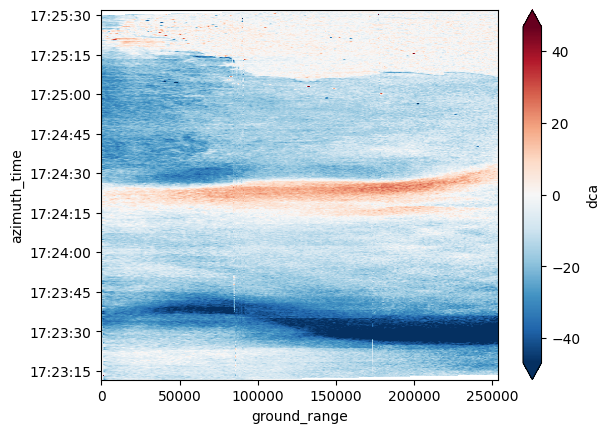

In [27]:
interp = LinearNDInterpolator(list(zip(df.lon.values, df.lat.values)), df.dca.values)

dca_interp = interp(S1.NRCS_VV.lon.values, S1.NRCS_VV.lat.values)
S1['dca'] = (['azimuth_time', 'ground_range'], dca_interp)
# dca
S1.dca.plot(robust = True)